<a href="https://colab.research.google.com/github/kSahatova/MMA-CourseProject/blob/main/Lab4_StationarityOfTheProcesses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**For this lab you need subsample with timeseries, spatial fields or temporal
spatial fields.**

Step 1. Choose about 3-6 variables from your dataset (2-3 – target variables, the rest -
predictors).

Step 2. Analyze stationarity of a process (for mathematical expectation and variance) for all
chosen variables. Make them more stationary if needed.

Step 3. Analyze covariance or correlation function for chosen target variables and mutual
correlation functions among predictors and targets.

Step 4. Filter high frequencies (noise) with chosen 2 filters for target variables.

Step 5. Estimate spectral density function for with and without filtering.

Step 6. Built auto-regression model filtered and non-filtered data. To analyze residual error
and to define appropriate order of model.

Step 7. Build model in a form of linear dynamical system, using chosen predictors. To analyze
residual error and to define appropriate order of model.


In [74]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.tsa.api as smt
from statsmodels.tsa import stattools
from datetime import datetime
from scipy import signal
from scipy.ndimage import filters
from scipy import stats
import warnings
import statsmodels.api as sm
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error #, mean_absolute_percentage_error



# Step 1. Choice of target variables and predictors

In [ ]:
source_data = pd.read_csv('/content/drive/My Drive/kc_house_data.csv')

In [ ]:
source_data = source_data[(source_data['price']<source_data['price'].quantile(0.93))&(source_data['sqft_living']<source_data['sqft_living'].quantile(0.95))&
      (source_data['sqft_above']<source_data['sqft_above'].quantile(0.95))& 
      (source_data['sqft_living15']<source_data['sqft_living15'].quantile(0.95))]

In [ ]:
source_data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [ ]:
#id - Unique ID for each home sold\n",
#date - Date of the home sale\n",
#price - Price of each home sold\n",
#bedrooms - Number of bedrooms\n",
#bathrooms - Number of bathrooms, where .5 accounts for a room with a toilet but no shower\n",
#sqft_living - Square footage of the apartments interior living space\n",
#sqft_lot - Square footage of the land space\n",
#floors - Number of floors\n",
#waterfront - A dummy variable for whether the apartment was overlooking the waterfront or not\n",
#view - An index from 0 to 4 of how good the view of the property was\n",
#condition - An index from 1 to 5 on the condition of the apartment,\n",
#grade - An index from 1 to 13, where 1-3 falls short of building construction and design, 7 has an average level of construction and design, and 11-13 have a high quality level of construction and design.\n",
#sqft_above - The square footage of the interior housing space that is above ground level\n",
#sqft_basement - The square footage of the interior housing space that is below ground level\n",
#yr_built - The year the house was initially built\n",
#yr_renovated - The year of the house’s last renovation\n",
#zipcode - What zipcode area the house is in\n",
#lat - Lattitude\n",
#long - Longitude\n",
#sqft_living15 - The square footage of interior housing living space for the nearest 15 neighbors\n",
#sqft_lot15 - The square footage of the land lots of the nearest 15 neighbors"


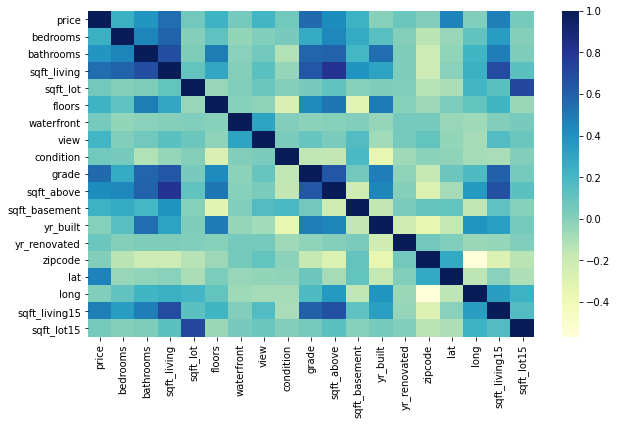

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))         # Sample figsize in inches
ax = sns.heatmap(source_data.iloc[:, 1:].corr(), cmap="YlGnBu" , annot=False)

Targets:
- price
- sqft_living

Predictors:
- sqft_above, grade
- sqt_above, bathrooms, bedrooms


In [ ]:
source_data.loc[:, 'date']=pd.to_datetime(source_data.loc[:,'date'])
source_data.loc[:, 'date']=source_data.loc[:, 'date'].dt.round('1d')

def aggregation(data,  agg_col: str):
    agg_data = data.groupby('date',as_index=False).agg({agg_col: "sum"})
    return agg_data.sort_values(by=['date'])


df_price_year = aggregation(source_data, 'price')
df_sqliving_year = aggregation(source_data, 'sqft_living')
df_sqabove_year = aggregation(source_data, 'sqft_above')
df_grade_year = aggregation(source_data, 'grade') 
df_bed_year = aggregation(source_data, 'bedrooms')
df_bath_year = aggregation(source_data, 'bathrooms')


In [ ]:
dfs = [df_price_year,df_sqliving_year, df_sqabove_year, df_grade_year, df_bed_year, df_bath_year]

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(16, 18))


d = 0
for i in range(3):
  for j in range(2):
      ax[i, j].plot(dfs[d][dfs[d].columns[0]], dfs[d][dfs[d].columns[1]])
      ax[i, j].set(xlabel=dfs[d].columns[0], ylabel=dfs[d].columns[1])
      plt.setp(ax[i, j].xaxis.get_majorticklabels(), rotation=45)
      ax[i, j].grid()
      d += 1
plt.savefig('vars')


# Step 2. Analysis of stationarity of the chosen variables

In [ ]:
for df in dfs:
  result = smt.stattools.adfuller(df[df.columns[1]])
  print(f'Augmented Dickey-Fuller for dependency of {df.columns[1]} on {df.columns[0]}:\
  \nStatistic value = %5f\np-value = %5f\n' % (result[0], result[1]))


In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
pd.__version__
df_price_year.index=pd.date_range(freq="m",start=df_price_year['date'][0],periods=len(df_price_year['date']))

#moving average
result = seasonal_decompose((df_price_year["price"]), model='additive')
fig=result.plot()
fig.set_figheight(10)
fig.set_figwidth(10)
plt.savefig('decompose_data')
plt.show()

In [ ]:
df_sqliving_year.index=pd.date_range(freq="m",start=df_sqliving_year['date'][0],periods=len(df_sqliving_year['date']))

#moving average
result = seasonal_decompose((df_sqliving_year["sqft_living"]), model='additive')
fig=result.plot()
fig.set_figheight(10)
fig.set_figwidth(10)

plt.show()

In [ ]:
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

st_dfs = []
for df in dfs:
  diff = difference(df[df.columns[1]])
  df[df.columns[1]] = df[df.columns[1]]-diff
  df = df.drop(df.index[len(df)-1])
  st_dfs.append(df)
  print(len(df))

In [ ]:
df_price_year = df_price_year.drop(df_price_year.index[len(df_price_year)-1])
df_sqliving_year = df_sqliving_year.drop(df_sqliving_year.index[len(df_sqliving_year)-1])
df_sqabove_year = df_sqabove_year.drop(df_sqabove_year.index[len(df_grade_year)-1])
df_grade_year = df_grade_year.drop(df_grade_year.index[len(df_bath_year)-1])
df_bath_year = df_bath_year.drop(df_bath_year.index[len(df_bath_year)-1])
df_bed_year = df_bed_year.drop(df_bed_year.index[len(df_bed_year)-1])
len(df_price_year)

371

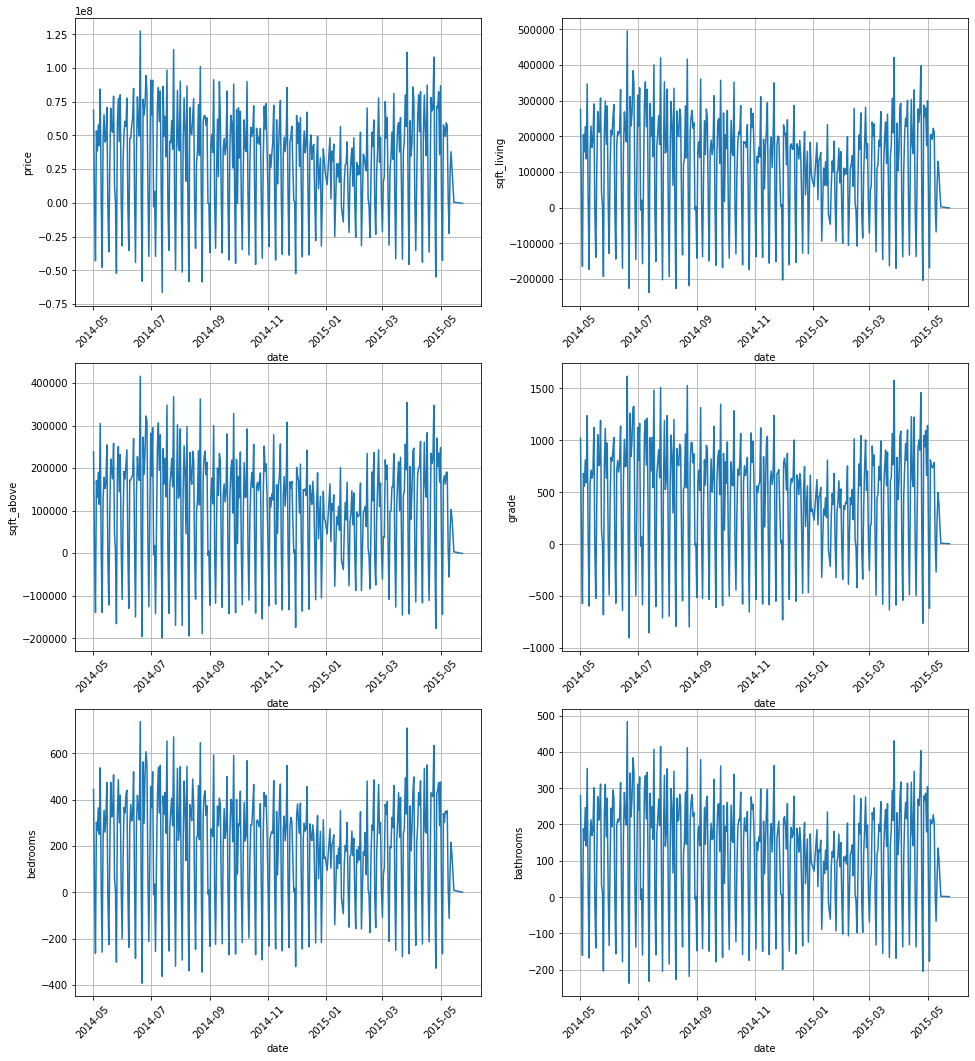

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(16, 18))

d = 0
for i in range(3):
  for j in range(2):
      ax[i, j].plot(st_dfs[d][st_dfs[d].columns[0]], st_dfs[d][st_dfs[d].columns[1]])
      ax[i, j].set(xlabel=st_dfs[d].columns[0], ylabel=st_dfs[d].columns[1])
      plt.setp(ax[i, j].xaxis.get_majorticklabels(), rotation=45)
      ax[i, j].grid()
      d += 1
plt.savefig('stat_vars')


In [ ]:
for df in st_dfs:
  result = smt.stattools.adfuller(df[df.columns[1]])
  print(f'Augmented Dickey-Fuller for dependency of {df.columns[1]} on {df.columns[0]}:\
  \nStatistic value = %5f\np-value = %5f\n' % (result[0], result[1]))

Augmented Dickey-Fuller for dependency of price on date:  
Statistic value = -2.388794
p-value = 0.144924

Augmented Dickey-Fuller for dependency of sqft_living on date:  
Statistic value = -2.286604
p-value = 0.176325

Augmented Dickey-Fuller for dependency of sqft_above on date:  
Statistic value = -2.302625
p-value = 0.171123

Augmented Dickey-Fuller for dependency of grade on date:  
Statistic value = -2.649269
p-value = 0.083236

Augmented Dickey-Fuller for dependency of bedrooms on date:  
Statistic value = -2.648399
p-value = 0.083401

Augmented Dickey-Fuller for dependency of bathrooms on date:  
Statistic value = -2.268837
p-value = 0.182216



# Step 3. Avtocovariance function for chosen target variables and mutual correlation functions among predictors and targets

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['diff']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


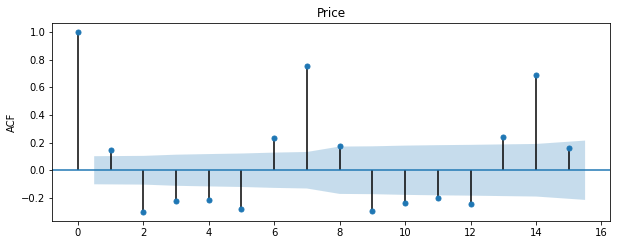

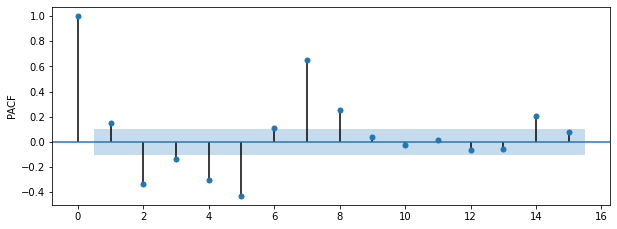

In [ ]:
import statsmodels.api as sm
%pylab inline

plt.figure(figsize=(10,8))

# autocorrelcation
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df_price_year['price'].values.squeeze(), lags=15, ax=ax)
plt.ylabel('ACF')
plt.title('Price')
pylab.show()

plt.figure(figsize=(10,8))

# partial autocorrelation 
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df_price_year['price'].values.squeeze(), lags=15, ax=ax, title=None)
plt.ylabel('PACF')
pylab.show()


Populating the interactive namespace from numpy and matplotlib


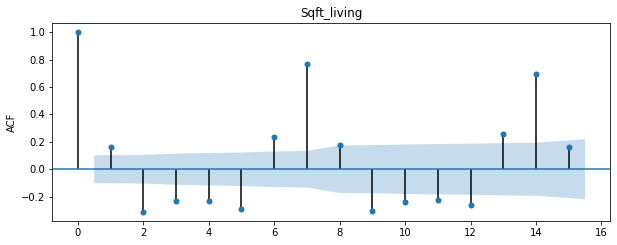

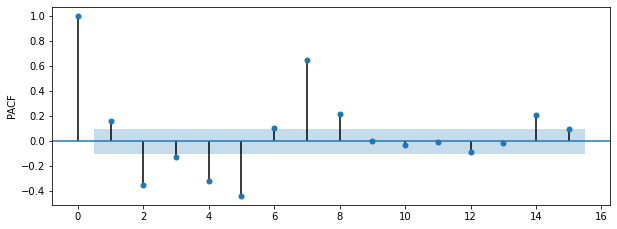

In [ ]:
import statsmodels.api as sm
%pylab inline

plt.figure(figsize=(10,8))

# autocorrelcation
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df_sqliving_year['sqft_living'].values.squeeze(), lags=15, ax=ax)
plt.ylabel('ACF')
plt.title('Sqft_living')
pylab.show()

plt.figure(figsize=(10,8))

# partial autocorrelation 
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df_sqliving_year['sqft_living'].values.squeeze(), lags=15, ax=ax, title=None)
plt.ylabel('PACF')
pylab.show()


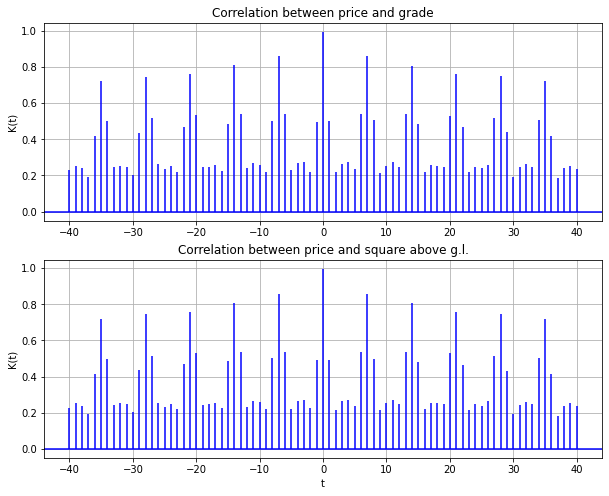

In [ ]:
#Plot graph
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(211)
  
# cross correlation using
# xcorr() function
ax1.xcorr(df_price_year['price'], df_grade_year['grade'], usevlines=True,
          maxlags=40, normed=True, color='blue')
ax1.set_ylabel('K(t)')
ax1.set_title('Correlation between price and grade')  
ax1.grid()

ax2 = fig.add_subplot(212)
ax2.xcorr(df_price_year['price'], df_sqabove_year['sqft_above'], usevlines=True,
          maxlags=40, normed=True, color='blue')
ax2.set_ylabel('K(t)')
ax2.set_xlabel('t')
ax2.set_title('Correlation between price and square above g.l.')  
ax2.grid()
 
# show final plotted graph
plt.show()

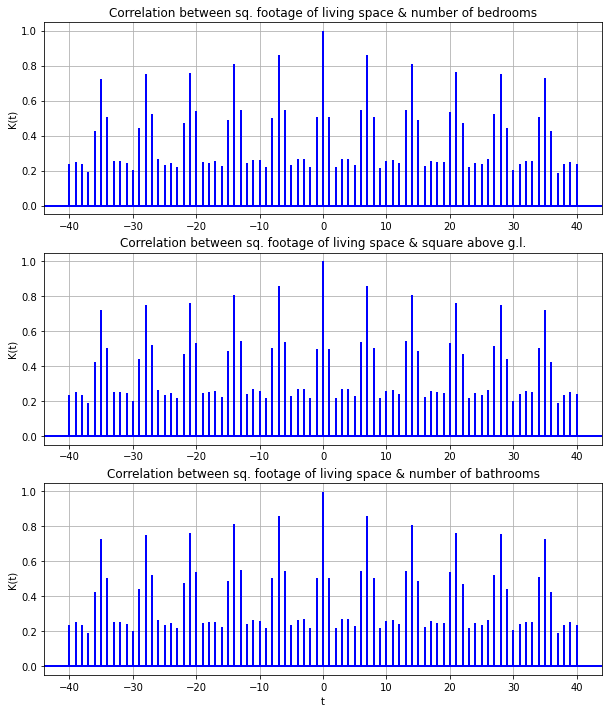

In [ ]:
#Plot graph
fig = plt.figure(figsize=(10, 12))

ax1 = fig.add_subplot(311)  
ax1.xcorr(df_sqliving_year['sqft_living'], df_bed_year['bedrooms'], usevlines=True,
          maxlags=40, normed=True, lw=2, color='blue')
ax1.set_ylabel('K(t)')
ax1.set_title('Correlation between sq. footage of living space & number of bedrooms')  
ax1.grid()

ax2 = fig.add_subplot(312)
ax2.xcorr(df_sqliving_year['sqft_living'], df_sqabove_year['sqft_above'], usevlines=True,
          maxlags=40, normed=True, lw=2, color='blue')
ax2.set_ylabel('K(t)')
ax2.set_title('Correlation between sq. footage of living space & square above g.l.')  
ax2.grid()
 
ax3 = fig.add_subplot(313)
ax3.xcorr(df_sqliving_year['sqft_living'], df_bath_year['bathrooms'], usevlines=True,
          maxlags=40, normed=True, lw=2, color='blue')
ax3.set_ylabel('K(t)')
ax3.set_xlabel('t')
ax3.set_title('Correlation between sq. footage of living space & number of bathrooms')  
ax3.grid()
 
# show final plotted graph
plt.show()

# Step 4/5. Filtering of target variables from high frequencies. Estimation of spectral density before and after filtering


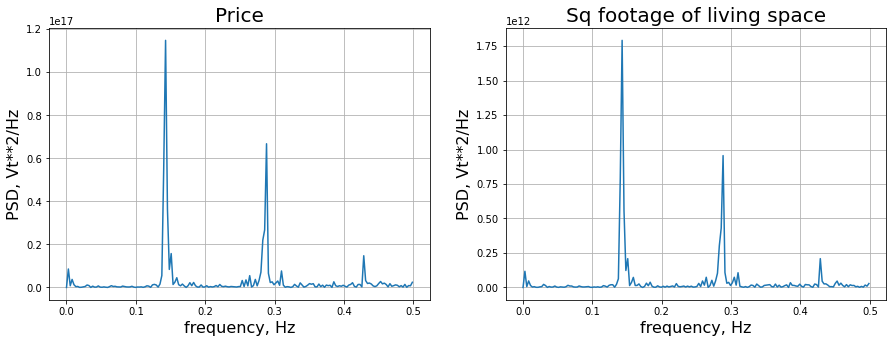

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

f, p = signal.periodogram(x=df_price_year['price'],fs=1,window=None)
ax[0].plot(f, p)
ax[0].set_xlabel('frequency, Hz',fontsize=16)
ax[0].set_ylabel('PSD, Vt**2/Hz',fontsize=16)
ax[0].set_title('Price',fontsize=20)
ax[0].grid()

f, p = signal.periodogram(x=df_sqliving_year['sqft_living'],fs=1,window=None)
ax[1].plot(f, p)
ax[1].set_xlabel('frequency, Hz',fontsize=16)
ax[1].set_ylabel('PSD, Vt**2/Hz',fontsize=16)
ax[1].set_title('Sq footage of living space',fontsize=20)
ax[1].grid()
fig.savefig('pg1.png')


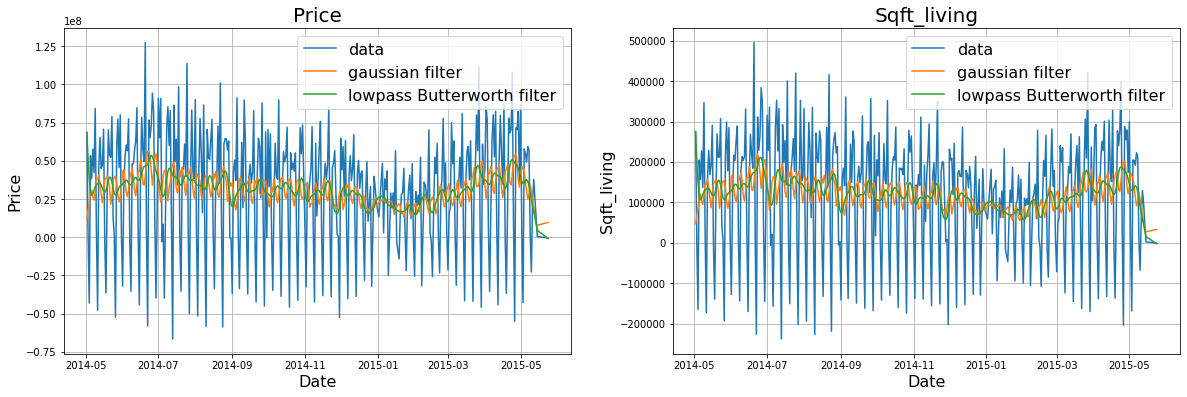

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

fs = 1000 #sampling frequency
fc = 100  #cut frequency
w = fc / (fs / 2) #normalisation
but_list = []
gaus_list = []
dataframes = [df_price_year, df_sqliving_year]

#gauss filter parameters
windows_size=10
gauss_sd=10
#windows setup
window = signal.gaussian(windows_size, gauss_sd)

for i, df in enumerate(dataframes):
  ax[i].plot(df[df.columns[0]], df[df.columns[1]], label='data')

  output_gauss=signal.convolve(df[df.columns[1]], window/window.sum(), mode='same')
  ax[i].plot(df[df.columns[0]], output_gauss, label='gaussian filter')
  gaus_list.append(output_gauss)
  ax[i].set_ylabel(df.columns[1].capitalize(), fontsize=16)

  ax[i].set_title(df.columns[1].capitalize(), fontsize = 20)
  ax[i].grid()

  b, a = signal.butter(4, w, 'low')
  filtered_var = signal.filtfilt(b, a, df[df.columns[1]])
  but_list.append(filtered_var)
  ax[i].plot(df[df.columns[0]], filtered_var, label='lowpass Butterworth filter' )
  ax[i].legend(prop={"size":16})
  ax[i].set_xlabel(df.columns[0].capitalize(), fontsize=16)
  fig.savefig('fd.png')



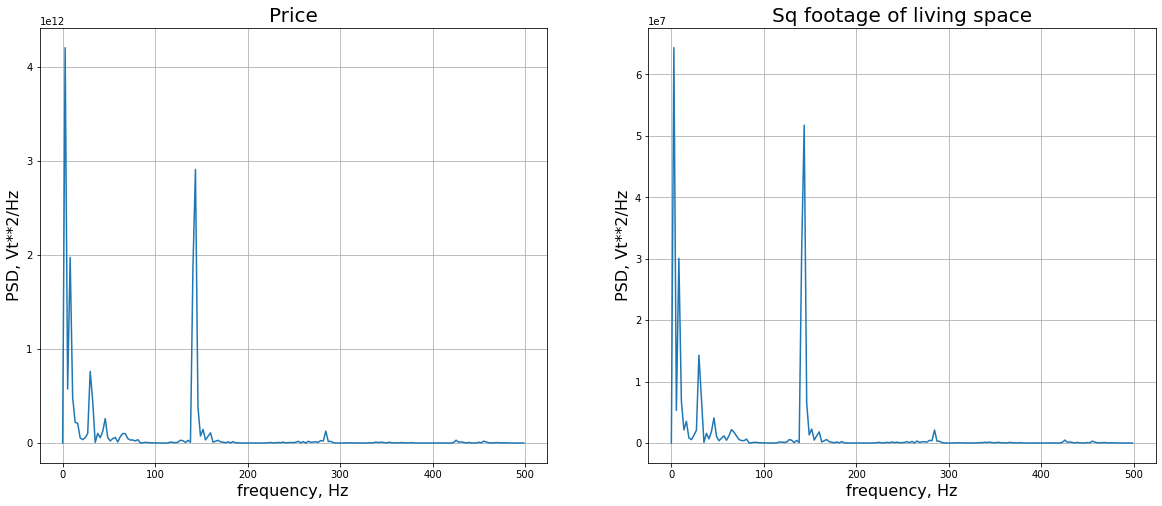

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
titles = ['Price', 'Sq footage of living space']

for i, (df, title) in enumerate(zip(gaus_list, titles)):
  f, p = signal.periodogram(x=df,fs=1000,window=None)
  ax[i].plot(f, p)
  ax[i].set_xlabel('frequency, Hz',fontsize=16)
  ax[i].set_ylabel('PSD, Vt**2/Hz',fontsize=16)
  ax[i].set_title(title, fontsize = 20)
  ax[i].grid()
  fig.savefig('pg_gaus.png')


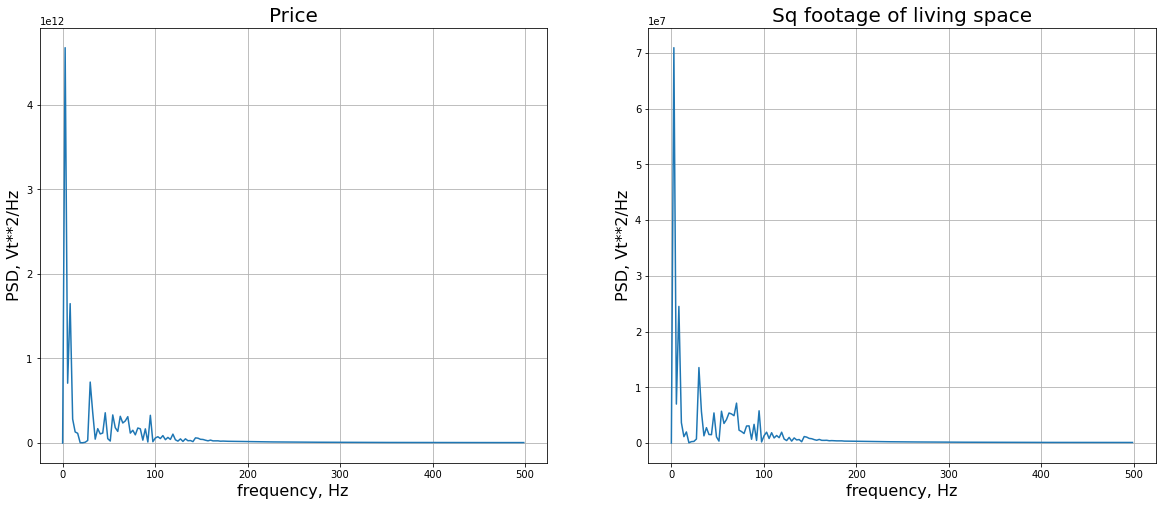

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
titles = ['Price', 'Sq footage of living space']

for i, (df, title) in enumerate(zip(but_list, titles)):
  f, p = signal.periodogram(x=df,fs=1000,window=None)
  ax[i].plot(f, p)
  ax[i].set_xlabel('frequency, Hz',fontsize=16)
  ax[i].set_ylabel('PSD, Vt**2/Hz',fontsize=16)
  ax[i].set_title(title,fontsize=20)
  ax[i].grid()
  fig.savefig('pg_but.png')


#  Step 6. Building of auto-regression model  for filtered and non-filtered data. Analysis of residual error and definition of the order of the model

# Initial "price". Order=6, 1, 7

In [62]:
# SARIMA parameters:
from itertools import product

ps = range(0, 8)
d=1
qs = range(0, 8)
Ps = range(0, 2)
D=1
Qs= range(0,1)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print(parameters_list)
print (u"Models to analyse by AIC:", len(parameters_list))

[(0, 0, 0, 0), (0, 0, 1, 0), (0, 1, 0, 0), (0, 1, 1, 0), (0, 2, 0, 0), (0, 2, 1, 0), (0, 3, 0, 0), (0, 3, 1, 0), (0, 4, 0, 0), (0, 4, 1, 0), (0, 5, 0, 0), (0, 5, 1, 0), (0, 6, 0, 0), (0, 6, 1, 0), (0, 7, 0, 0), (0, 7, 1, 0), (1, 0, 0, 0), (1, 0, 1, 0), (1, 1, 0, 0), (1, 1, 1, 0), (1, 2, 0, 0), (1, 2, 1, 0), (1, 3, 0, 0), (1, 3, 1, 0), (1, 4, 0, 0), (1, 4, 1, 0), (1, 5, 0, 0), (1, 5, 1, 0), (1, 6, 0, 0), (1, 6, 1, 0), (1, 7, 0, 0), (1, 7, 1, 0), (2, 0, 0, 0), (2, 0, 1, 0), (2, 1, 0, 0), (2, 1, 1, 0), (2, 2, 0, 0), (2, 2, 1, 0), (2, 3, 0, 0), (2, 3, 1, 0), (2, 4, 0, 0), (2, 4, 1, 0), (2, 5, 0, 0), (2, 5, 1, 0), (2, 6, 0, 0), (2, 6, 1, 0), (2, 7, 0, 0), (2, 7, 1, 0), (3, 0, 0, 0), (3, 0, 1, 0), (3, 1, 0, 0), (3, 1, 1, 0), (3, 2, 0, 0), (3, 2, 1, 0), (3, 3, 0, 0), (3, 3, 1, 0), (3, 4, 0, 0), (3, 4, 1, 0), (3, 5, 0, 0), (3, 5, 1, 0), (3, 6, 0, 0), (3, 6, 1, 0), (3, 7, 0, 0), (3, 7, 1, 0), (4, 0, 0, 0), (4, 0, 1, 0), (4, 1, 0, 0), (4, 1, 1, 0), (4, 2, 0, 0), (4, 2, 1, 0), (4, 3, 0, 0), (4, 3

In [63]:

results = []
best_aic = float("inf")

# ignore warnings 
warnings.filterwarnings('ignore')

for param in parameters_list:
    
    #try except for the case of wrong parameters
    try:
        model=sm.tsa.statespace.SARIMAX(df_price_year['price'], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
        
    #print wrong parameters and go on
    # AIC criteria: 
    except ValueError:
            continue
    #except LinAlgError:
    #        continue
    aic = model.aic

    # save best model, aic, parameters
    if (aic < best_aic):
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    

In [ ]:
model.aic

13023.865878368602

In [64]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

       parameters           aic
125  (7, 6, 1, 0)  13315.596815
111  (6, 7, 1, 0)  13318.436302
127  (7, 7, 1, 0)  13318.456786
109  (6, 6, 1, 0)  13318.848000
121  (7, 4, 1, 0)  13325.869216


In [ ]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              price   No. Observations:                  369
Model:             SARIMAX(6, 1, 7)x(1, 1, 0, 12)   Log Likelihood               -6496.082
Date:                            Wed, 21 Apr 2021   AIC                          13022.165
Time:                                    10:42:29   BIC                          13080.289
Sample:                                         0   HQIC                         13045.285
                                            - 369                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8739      0.176     -4.968      0.000      -1.219      -0.529
ar.L2         -0.8032      0.048   

Student test: p=0.231848
Dickey-Fuller test: p=0.0000000000000000000000000


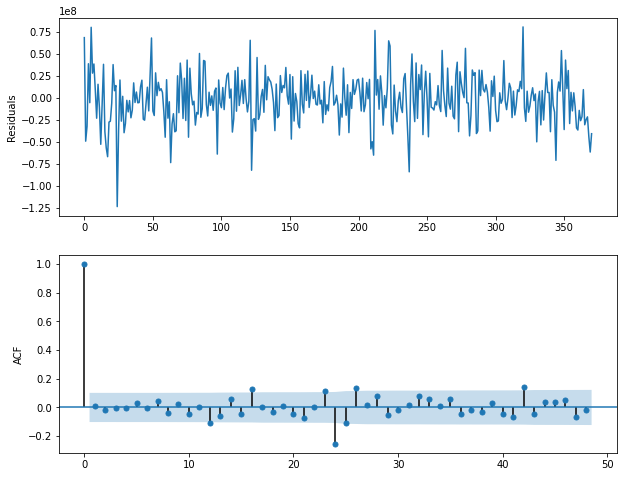

In [65]:
# residuals
plt.figure(figsize=(10,8))
ax = plt.subplot(211)

plt.plot(best_model.resid)
plt.ylabel('Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid.squeeze(), lags=48, ax=ax, title=None)
plt.ylabel('ACF')
plt.savefig('res1.png')

print("Student test: p=%f" % stats.ttest_1samp(best_model.resid, 0)[1])
print("Dickey-Fuller test: p=%.25f" % sm.tsa.stattools.adfuller(best_model.resid)[1])

Normality of residuals: 
mean= -1363152.904503897, variance= 425856092400730.7


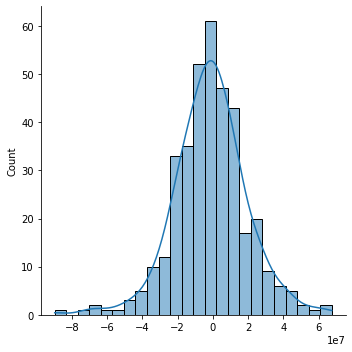

In [ ]:
print(f'Normality of residuals: \nmean= {best_model.resid.mean()}, variance= {best_model.resid.var()}')
sns.displot(best_model.resid, kde=True);

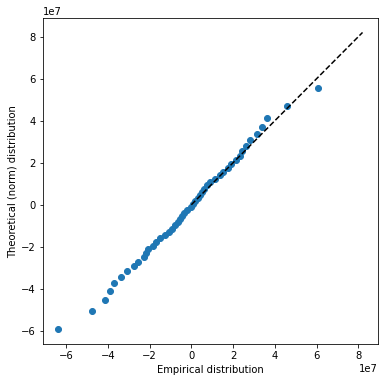

In [67]:
import scipy
params = stats.norm.fit(model.resid)
x = np.linspace(0, np.max(model.resid))

percs = np.linspace(0, 100)
qn_first = np.percentile(model.resid, percs)
qn_gamma = scipy.stats.norm.ppf(percs / 100.0, *params)

# Building a quantile biplot
plt.figure(figsize=(6, 6))
plt.plot(qn_first, qn_gamma, ls="", marker="o", markersize=6)
plt.plot(x, x, color="k", ls="--")
plt.xlabel(f'Empirical distribution')
plt.ylabel('Theoretical (norm) distribution')

plt.show()

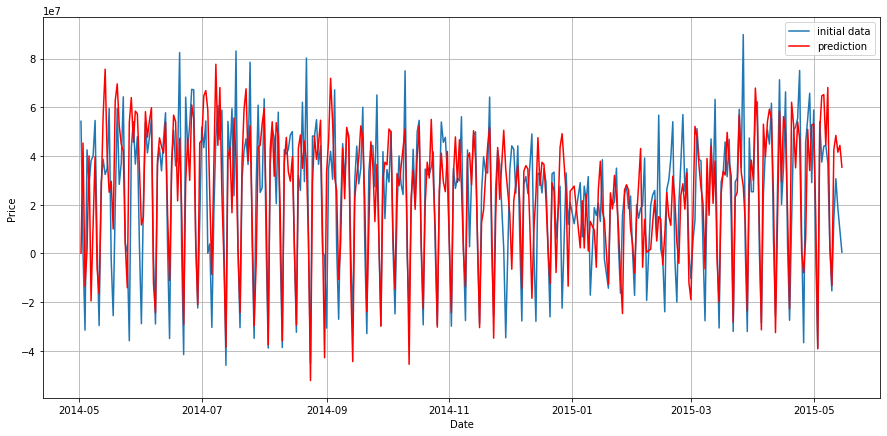

In [ ]:
   
# visualise and compare  
#df_price_year['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize=(15,7))
plt.plot(df_price_year['date'], df_price_year['price'], label='initial data')
plt.plot(df_price_year['date'], best_model.predict(start=0, end=368), color='r', label='prediction')
plt.legend()
plt.ylabel('Price');
plt.xlabel('Date');
plt.savefig('prediction_price_or7_id')
plt.grid()

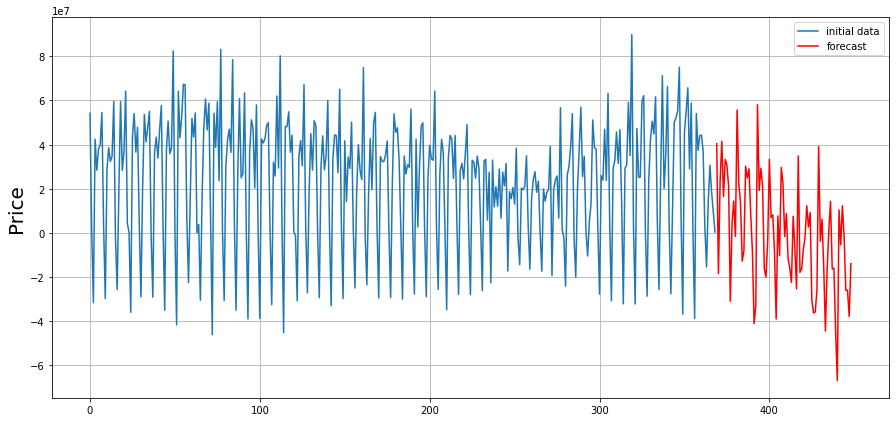

In [ ]:
# visualise and compare  
#df_price_year['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize=(15,7))
plt.plot( df_price_year['price'], label='initial data')  # df_price_year['date'],
plt.plot( best_model.forecast(steps=80), color='r', label='forecast') # df_price_year['date'],
plt.legend()
plt.ylabel('Price', fontsize=20);
plt.savefig('forcast_price_or7_id')
plt.grid()

In [ ]:

prediction = best_model.predict(start=0, end=368)
print("MSE = ", mean_squared_error(df_price_year['price'], prediction))
print("MAE = ", mean_absolute_error(df_price_year['price'], prediction))
print("MAPE = ", round(np.mean(np.abs(df_price_year['price']-prediction)/df_price_year['price'])*100,3))
print("R^2 = ", r2_score(df_price_year['price'], prediction ))

MSE =  426560196690566.44
MAE =  15378371.202323945
MAPE =  -3297.355
R^2 =  0.47196726645329456


In [ ]:
len(df_price_year.loc[:250, 'price']), len(df_price_year.loc[251:, 'price']), df_price_year.loc[370, 'price']

(251, 120, -419000.0)

# Initial "price". Order = 2,1,1 

In [ ]:
model = sm.tsa.statespace.SARIMAX(df_price_year['price'], order=(2, d, 1), seasonal_order=(1, D, [], 12)).fit(disp=-1)

In [ ]:
print(model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              price   No. Observations:                  369
Model:             SARIMAX(2, 1, 1)x(1, 1, 0, 12)   Log Likelihood               -6717.301
Date:                            Wed, 21 Apr 2021   AIC                          13444.602
Time:                                    10:44:40   BIC                          13463.977
Sample:                                         0   HQIC                         13452.309
                                            - 369                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4114      0.098      4.196      0.000       0.219       0.604
ar.L2         -0.4145      0.116   

Student test: p=0.191873
Dickey-Fuller test: p=0.0891052592043838354030072


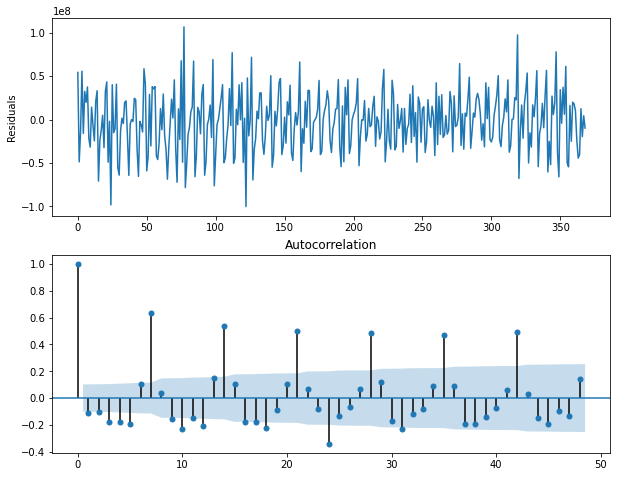

In [ ]:
plt.figure(figsize=(10,8))

ax = plt.subplot(211)
plt.plot(model.resid)
plt.ylabel('Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(model.resid.squeeze(), lags=48, ax=ax)
plt.savefig('res_id_2.png')

print("Student test: p=%f" % stats.ttest_1samp(model.resid, 0)[1])
print("Dickey-Fuller test: p=%.25f" % sm.tsa.stattools.adfuller(model.resid)[1])

Populating the interactive namespace from numpy and matplotlib
Normality of residuals: 
mean= -2314530.669044181, variance= 425856092400730.7


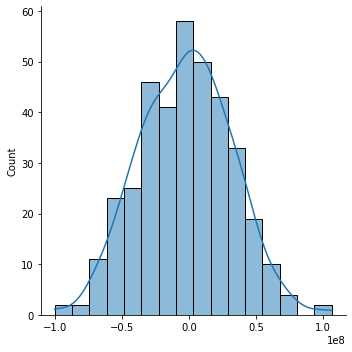

In [ ]:
%pylab inline
print(f'Normality of residuals: \nmean= {model.resid.mean()}, variance= {best_model.resid.var()}')
sns.displot(model.resid, kde=True)
plt.savefig('res_dist_2.png')
pylab.show()

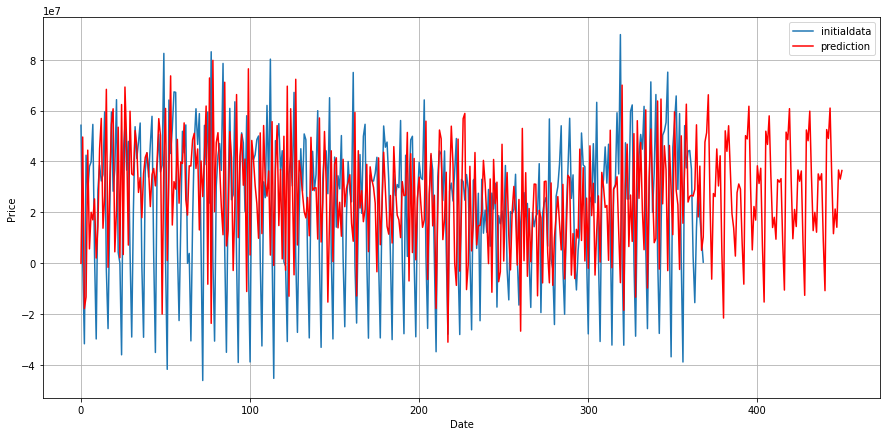

In [ ]:
# visualise and compare  

plt.figure(figsize=(15,7))
plt.plot( df_price_year['price'], label='initialdata')
plt.plot(model.predict(start=0, end=450), color='r', label='prediction')
plt.legend()
plt.ylabel('Price');
plt.xlabel('Date');
plt.grid()
plt.savefig('pred_price_2')
pylab.show()

In [ ]:
prediction = model.predict(start=0, end=368)
print("MSE = ", mean_squared_error(df_price_year['price'], prediction))
print("MAE = ", mean_absolute_error(df_price_year['price'], prediction))
print("MAPE = ", round(np.mean(np.abs(df_price_year['price']-prediction)/df_price_year['price'])*100,3))
print("R^2 = ", r2_score(df_price_year['price'], prediction ))

MSE =  1158588550289903.2
MAE =  27404513.98015772
MAPE =  -382.858
R^2 =  -0.4342001058980238


In [ ]:
# SARIMA parameters:
from itertools import product

ps = range(0, 8)
d=1
qs = range(0, 8)
Ps = range(0, 2)
D=1
Qs= range(0,1)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print(parameters_list)
print (u"Models to analyse by AIC:", len(parameters_list))

[(0, 0, 0, 0), (0, 0, 1, 0), (0, 1, 0, 0), (0, 1, 1, 0), (0, 2, 0, 0), (0, 2, 1, 0), (0, 3, 0, 0), (0, 3, 1, 0), (0, 4, 0, 0), (0, 4, 1, 0), (0, 5, 0, 0), (0, 5, 1, 0), (0, 6, 0, 0), (0, 6, 1, 0), (0, 7, 0, 0), (0, 7, 1, 0), (1, 0, 0, 0), (1, 0, 1, 0), (1, 1, 0, 0), (1, 1, 1, 0), (1, 2, 0, 0), (1, 2, 1, 0), (1, 3, 0, 0), (1, 3, 1, 0), (1, 4, 0, 0), (1, 4, 1, 0), (1, 5, 0, 0), (1, 5, 1, 0), (1, 6, 0, 0), (1, 6, 1, 0), (1, 7, 0, 0), (1, 7, 1, 0), (2, 0, 0, 0), (2, 0, 1, 0), (2, 1, 0, 0), (2, 1, 1, 0), (2, 2, 0, 0), (2, 2, 1, 0), (2, 3, 0, 0), (2, 3, 1, 0), (2, 4, 0, 0), (2, 4, 1, 0), (2, 5, 0, 0), (2, 5, 1, 0), (2, 6, 0, 0), (2, 6, 1, 0), (2, 7, 0, 0), (2, 7, 1, 0), (3, 0, 0, 0), (3, 0, 1, 0), (3, 1, 0, 0), (3, 1, 1, 0), (3, 2, 0, 0), (3, 2, 1, 0), (3, 3, 0, 0), (3, 3, 1, 0), (3, 4, 0, 0), (3, 4, 1, 0), (3, 5, 0, 0), (3, 5, 1, 0), (3, 6, 0, 0), (3, 6, 1, 0), (3, 7, 0, 0), (3, 7, 1, 0), (4, 0, 0, 0), (4, 0, 1, 0), (4, 1, 0, 0), (4, 1, 1, 0), (4, 2, 0, 0), (4, 2, 1, 0), (4, 3, 0, 0), (4, 3

# Filtered "price". Order = 6, 1, 7







In [68]:
model = sm.tsa.statespace.SARIMAX(gaus_list[0], order=(6, d, 7), seasonal_order=(1, 1, 0, 12)).fit(disp=-1)

In [69]:
print(model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  371
Model:             SARIMAX(6, 1, 7)x(1, 1, 0, 12)   Log Likelihood               -5891.439
Date:                            Wed, 21 Apr 2021   AIC                          11812.878
Time:                                    23:44:49   BIC                          11871.086
Sample:                                         0   HQIC                         11836.027
                                            - 371                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3235      0.144      2.240      0.025       0.041       0.607
ar.L2         -0.7520      0.104   

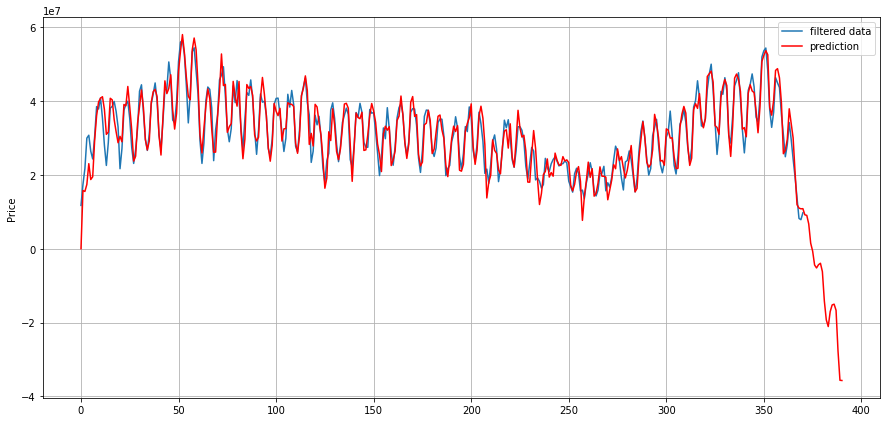

In [71]:
# visualise and compare  

plt.figure(figsize=(15,7))
plt.plot( gaus_list[0], label='filtered data')
plt.plot(model.predict(start=0, end=390), color='r', label='prediction')
plt.legend()
plt.ylabel('Price');
plt.grid()
plt.savefig('pred_price_7fd')
pylab.show()

Student test: p=0.822206
Dickey-Fuller test: p=0.0000868437599810264560050


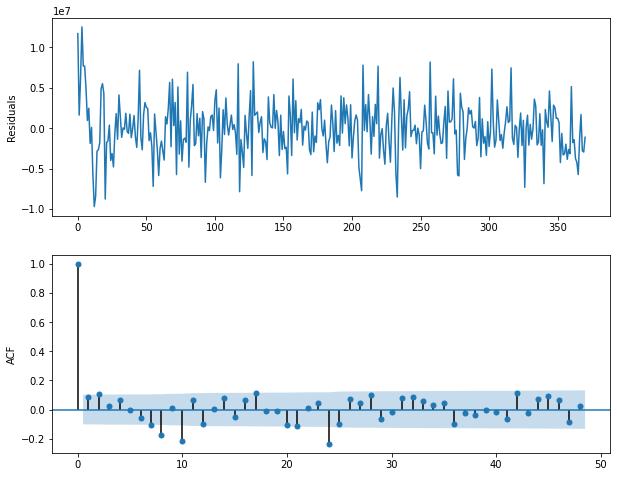

In [77]:
# residuals
plt.figure(figsize=(10,8))
ax = plt.subplot(211)

plt.plot(model.resid)
plt.ylabel('Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(model.resid.squeeze(), lags=48, ax=ax, title=None)
plt.ylabel('ACF')
plt.savefig('res1.png')

print("Student test: p=%f" % stats.ttest_1samp(model.resid, 0)[1])
print("Dickey-Fuller test: p=%.25f" % sm.tsa.stattools.adfuller(model.resid)[1])

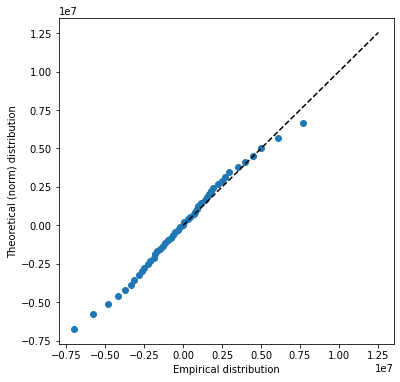

In [78]:
import scipy
params = stats.norm.fit(model.resid)
x = np.linspace(0, np.max(model.resid))

percs = np.linspace(0, 100)
qn_first = np.percentile(model.resid, percs)
qn_gamma = scipy.stats.norm.ppf(percs / 100.0, *params)

# Building a quantile biplot
plt.figure(figsize=(6, 6))
plt.plot(qn_first, qn_gamma, ls="", marker="o", markersize=6)
plt.plot(x, x, color="k", ls="--")
plt.xlabel(f'Empirical distribution')
plt.ylabel('Theoretical (norm) distribution')

plt.show()

Populating the interactive namespace from numpy and matplotlib
Normality of residuals: 
mean= -38289.91403732379, variance= 778965858437997.5


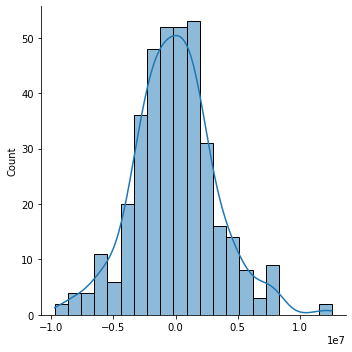

In [72]:
%pylab inline
print(f'Normality of residuals: \nmean= {model.resid.mean()}, variance= {best_model.resid.var()}')
sns.displot(model.resid, kde=True)
plt.savefig('res_dist_fd7.png')
pylab.show()

In [76]:
prediction = model.predict(start=0, end=370)
print("MSE = ", mean_squared_error(but_list[0], prediction))
print("MAE = ", mean_absolute_error(but_list[0], prediction))
print("MAPE = ", round(np.mean(np.abs(but_list[0]-prediction)/but_list[0])*100,3))
print("R^2 = ", r2_score(gaus_list[0], prediction ))

MSE =  69584133964093.05
MAE =  6463682.219130457
MAPE =  16.74
R^2 =  0.8752151226496953


# Filtered "price". Order = 2, 1, 1

In [ ]:
model = sm.tsa.statespace.SARIMAX(but_list[0], order=(2, d, 1), seasonal_order=(1, 1, 0, 12)).fit(disp=-1)

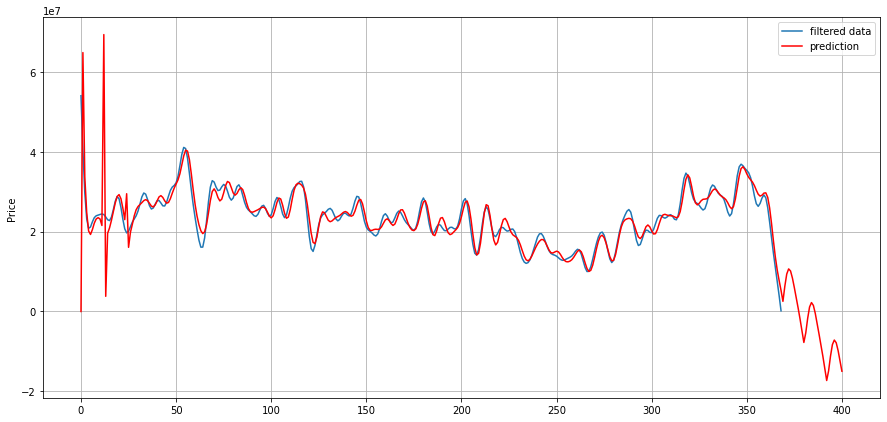

In [ ]:
# visualise and compare  

plt.figure(figsize=(15,7))
plt.plot( but_list[0], label='filtered data')
plt.plot(model.predict(start=0, end=400), color='r', label='prediction')
plt.legend()
plt.ylabel('Price');
plt.grid()
plt.savefig('pred_price_2fd')
pylab.show()

Populating the interactive namespace from numpy and matplotlib
Normality of residuals: 
mean= -97932.15747396175, variance= 19559546128958.992


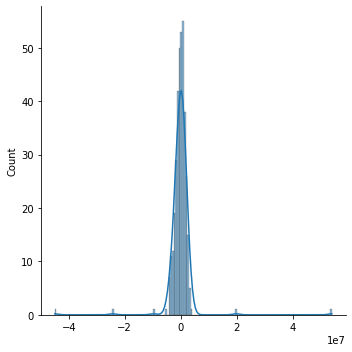

In [ ]:
%pylab inline
print(f'Normality of residuals: \nmean= {model.resid.mean()}, variance= {best_model.resid.var()}')
sns.displot(model.resid, kde=True)
plt.savefig('res_dist_2fd.png')
pylab.show()

In [ ]:
prediction = model.predict(start=0, end=368)
print("MSE = ", mean_squared_error(but_list[0], prediction))
print("MAE = ", mean_absolute_error(but_list[0], prediction))
print("MAPE = ", round(np.mean(np.abs(but_list[0]-prediction)/but_list[0])*100,3))
print("R^2 = ", r2_score(but_list[0], prediction ))

MSE =  18964419415720.96
MAE =  1695485.8936500666
MAPE =  15.234
R^2 =  0.5295007211381024


# Initial "sq_living". Order = 7, 1, 7

In [79]:
# SARIMA parameters:
from itertools import product

ps = range(0, 8)
d=1
qs = range(0, 8)
Ps = range(0, 2)
D=1
Qs= range(0,1)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print(parameters_list)
print (u"Models to analyse by AIC:", len(parameters_list))

[(0, 0, 0, 0), (0, 0, 1, 0), (0, 1, 0, 0), (0, 1, 1, 0), (0, 2, 0, 0), (0, 2, 1, 0), (0, 3, 0, 0), (0, 3, 1, 0), (0, 4, 0, 0), (0, 4, 1, 0), (0, 5, 0, 0), (0, 5, 1, 0), (0, 6, 0, 0), (0, 6, 1, 0), (0, 7, 0, 0), (0, 7, 1, 0), (1, 0, 0, 0), (1, 0, 1, 0), (1, 1, 0, 0), (1, 1, 1, 0), (1, 2, 0, 0), (1, 2, 1, 0), (1, 3, 0, 0), (1, 3, 1, 0), (1, 4, 0, 0), (1, 4, 1, 0), (1, 5, 0, 0), (1, 5, 1, 0), (1, 6, 0, 0), (1, 6, 1, 0), (1, 7, 0, 0), (1, 7, 1, 0), (2, 0, 0, 0), (2, 0, 1, 0), (2, 1, 0, 0), (2, 1, 1, 0), (2, 2, 0, 0), (2, 2, 1, 0), (2, 3, 0, 0), (2, 3, 1, 0), (2, 4, 0, 0), (2, 4, 1, 0), (2, 5, 0, 0), (2, 5, 1, 0), (2, 6, 0, 0), (2, 6, 1, 0), (2, 7, 0, 0), (2, 7, 1, 0), (3, 0, 0, 0), (3, 0, 1, 0), (3, 1, 0, 0), (3, 1, 1, 0), (3, 2, 0, 0), (3, 2, 1, 0), (3, 3, 0, 0), (3, 3, 1, 0), (3, 4, 0, 0), (3, 4, 1, 0), (3, 5, 0, 0), (3, 5, 1, 0), (3, 6, 0, 0), (3, 6, 1, 0), (3, 7, 0, 0), (3, 7, 1, 0), (4, 0, 0, 0), (4, 0, 1, 0), (4, 1, 0, 0), (4, 1, 1, 0), (4, 2, 0, 0), (4, 2, 1, 0), (4, 3, 0, 0), (4, 3

In [80]:

results = []
best_aic = float("inf")

# ignore warnings 
warnings.filterwarnings('ignore')

for param in parameters_list:
    
    #try except for the case of wrong parameters
    try:
        model=sm.tsa.statespace.SARIMAX(df_sqliving_year['sqft_living'], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
        
    #print wrong parameters and go on
    # AIC criteria: 
    except ValueError:
            continue
    #except LinAlgError:
    #        continue
    aic = model.aic

    # save best model, aic, parameters
    if (aic < best_aic):
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    

In [81]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

       parameters          aic
127  (7, 7, 1, 0)  9331.671099
111  (6, 7, 1, 0)  9331.709094
125  (7, 6, 1, 0)  9333.179979
109  (6, 6, 1, 0)  9335.581122
121  (7, 4, 1, 0)  9344.577484


In [94]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                        sqft_living   No. Observations:                  371
Model:             SARIMAX(7, 1, 7)x(1, 1, 0, 12)   Log Likelihood               -4649.836
Date:                            Thu, 22 Apr 2021   AIC                           9331.671
Time:                                    00:25:48   BIC                           9393.760
Sample:                                         0   HQIC                          9356.364
                                            - 371                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0849      0.547     -1.984      0.047      -2.157      -0.013
ar.L2         -0.9776      0.355   

Student test: p=0.209744
Dickey-Fuller test: p=0.0000000000000000000000000


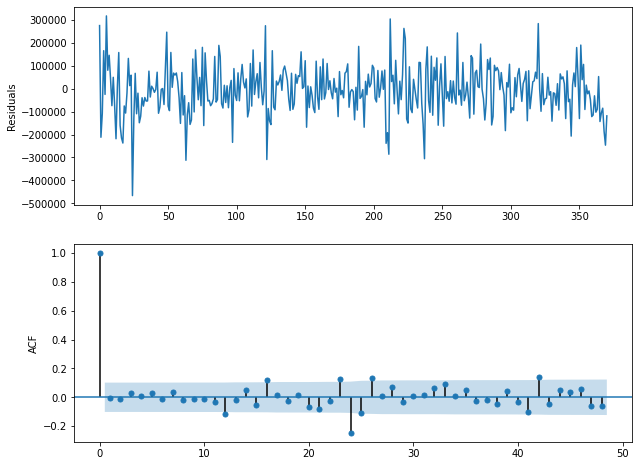

In [82]:
# residuals
plt.figure(figsize=(10,8))
ax = plt.subplot(211)

plt.plot(best_model.resid)
plt.ylabel('Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid.squeeze(), lags=48, ax=ax, title=None)
plt.ylabel('ACF')
plt.savefig('res_sq.png')

print("Student test: p=%f" % stats.ttest_1samp(best_model.resid, 0)[1])
print("Dickey-Fuller test: p=%.25f" % sm.tsa.stattools.adfuller(best_model.resid)[1])

Normality of residuals: 
mean= -6978.092955479992, variance= 11443370077.5678


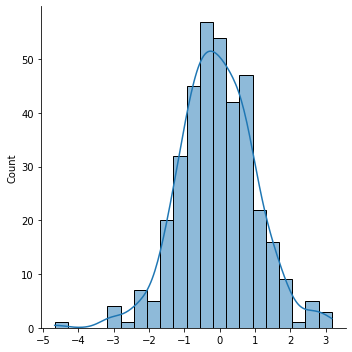

In [85]:
print(f'Normality of residuals: \nmean= {best_model.resid.mean()}, variance= {best_model.resid.var()}')
sns.displot(best_model.resid/100000, kde=True);

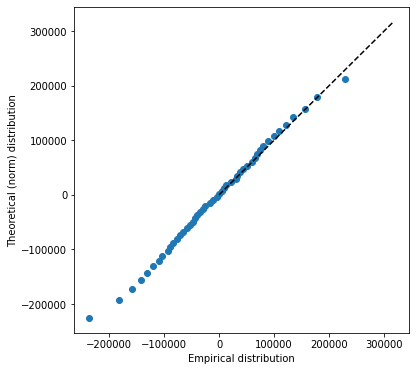

In [86]:
params = stats.norm.fit(model.resid)
x = np.linspace(0, np.max(model.resid))

percs = np.linspace(0, 100)
qn_first = np.percentile(model.resid, percs)
qn_gamma = scipy.stats.norm.ppf(percs / 100.0, *params)

# Building a quantile biplot
plt.figure(figsize=(6, 6))
plt.plot(qn_first, qn_gamma, ls="", marker="o", markersize=6)
plt.plot(x, x, color="k", ls="--")
plt.xlabel(f'Empirical distribution')
plt.ylabel('Theoretical (norm) distribution')

plt.show()

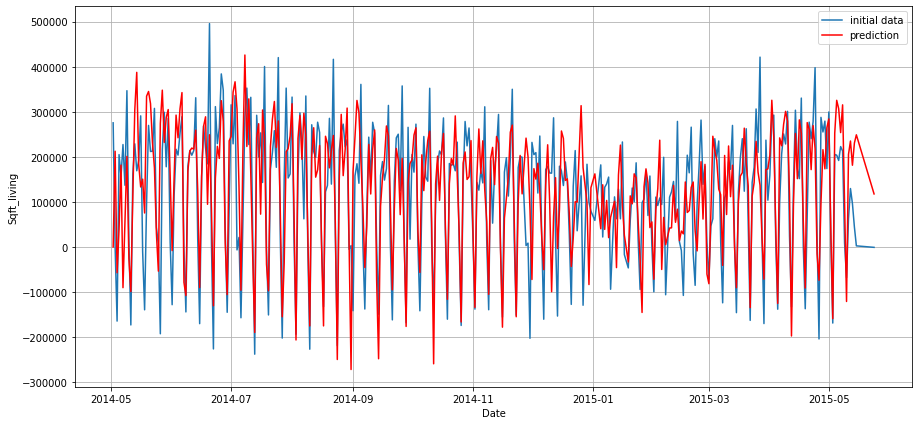

In [89]:
   
# visualise and compare  
#df_price_year['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize=(15,7))
plt.plot(df_sqliving_year['date'], df_sqliving_year['sqft_living'], label='initial data')
plt.plot(df_sqliving_year['date'], best_model.predict(start=0, end=370), color='r', label='prediction')
plt.legend()
plt.ylabel('Sqft_living');
plt.xlabel('Date');
plt.savefig('prediction_sqliv_or7_id')
plt.grid()

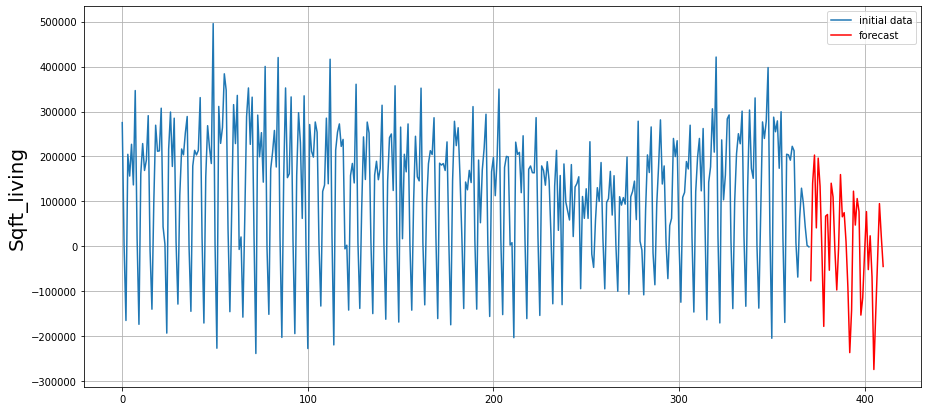

In [90]:
# visualise and compare  
#df_price_year['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize=(15,7))
plt.plot( df_sqliving_year['sqft_living'], label='initial data')  # df_price_year['date'],
plt.plot( best_model.forecast(steps=40), color='r', label='forecast') # df_price_year['date'],
plt.legend()
plt.ylabel('Sqft_living', fontsize=20);
plt.savefig('forcast_sqliv_or7_id')
plt.grid()

In [93]:
prediction = best_model.predict(start=0, end=370)
print("MSE = ", mean_squared_error(df_sqliving_year['sqft_living'], prediction))
print("MAE = ", mean_absolute_error(df_sqliving_year['sqft_living'], prediction))
print("MAPE = ", round(np.mean(np.abs(df_sqliving_year['sqft_living']-prediction)/df_sqliving_year['sqft_living'])*100,3))
print("R^2 = ", r2_score(df_sqliving_year['sqft_living'], prediction ))

MSE =  11461219195.581266
MAE =  83105.17558782478
MAPE =  274.931
R^2 =  0.47534107283545945


# Filtered "sq_living". Order = 7, 1, 7

In [105]:
model_sq = sm.tsa.statespace.SARIMAX(gaus_list[1], order=(7, d, 7), seasonal_order=(1, 1, 0, 12)).fit(disp=-1)

In [106]:
print(model_sq.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  371
Model:             SARIMAX(7, 1, 7)x(1, 1, 0, 12)   Log Likelihood               -3887.041
Date:                            Thu, 22 Apr 2021   AIC                           7806.081
Time:                                    00:32:42   BIC                           7868.170
Sample:                                         0   HQIC                          7830.774
                                            - 371                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4420      0.121      3.650      0.000       0.205       0.679
ar.L2         -0.8878      0.139   

Student test: p=0.804761
Dickey-Fuller test: p=0.0002146875156995562729245


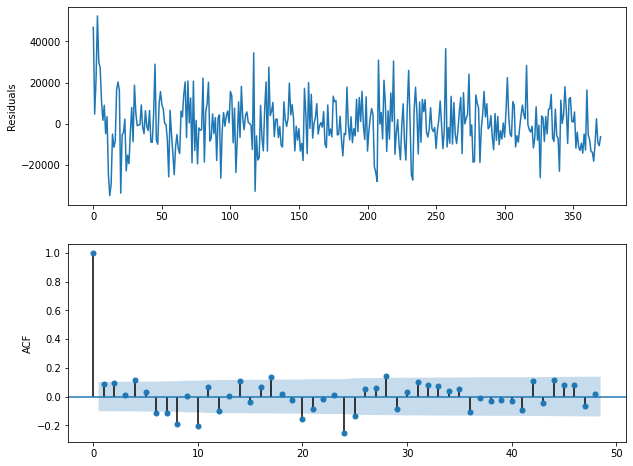

In [107]:
# residuals
plt.figure(figsize=(10,8))
ax = plt.subplot(211)

plt.plot(model_sq.resid)
plt.ylabel('Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(model_sq.resid.squeeze(), lags=48, ax=ax, title=None)
plt.ylabel('ACF')
plt.savefig('res_sq.png')

print("Student test: p=%f" % stats.ttest_1samp(model_sq.resid, 0)[1])
print("Dickey-Fuller test: p=%.25f" % sm.tsa.stattools.adfuller(model_sq.resid)[1])

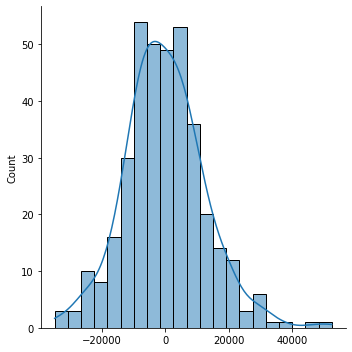

In [108]:
sns.displot(model_sq.resid, kde=True);

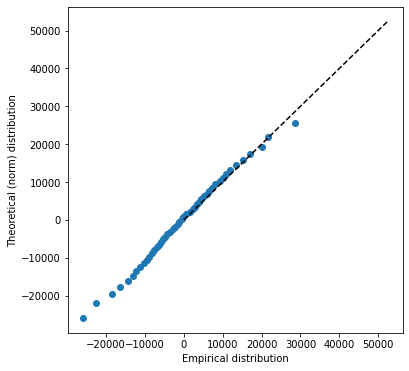

In [109]:
params = stats.norm.fit(model_sq.resid)
x = np.linspace(0, np.max(model_sq.resid))

percs = np.linspace(0, 100)
qn_first = np.percentile(model_sq.resid, percs)
qn_gamma = scipy.stats.norm.ppf(percs / 100.0, *params)

# Building a quantile biplot
plt.figure(figsize=(6, 6))
plt.plot(qn_first, qn_gamma, ls="", marker="o", markersize=6)
plt.plot(x, x, color="k", ls="--")
plt.xlabel(f'Empirical distribution')
plt.ylabel('Theoretical (norm) distribution')

plt.show()

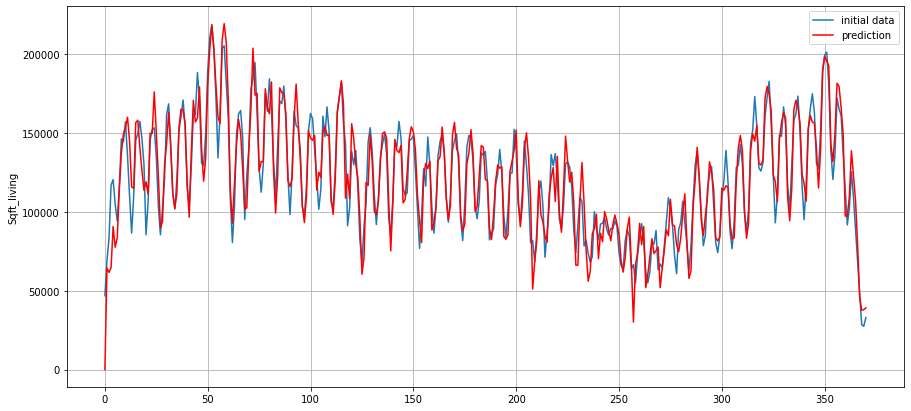

In [112]:
# visualise and compare  
plt.figure(figsize=(15,7))
plt.plot( gaus_list[1], label='initial data')
plt.plot( model_sq.predict(start=0, end=370), color='r', label='prediction')
plt.legend()
plt.ylabel('Sqft_living');
plt.savefig('prediction_sqliv_or7_fd')
plt.grid()

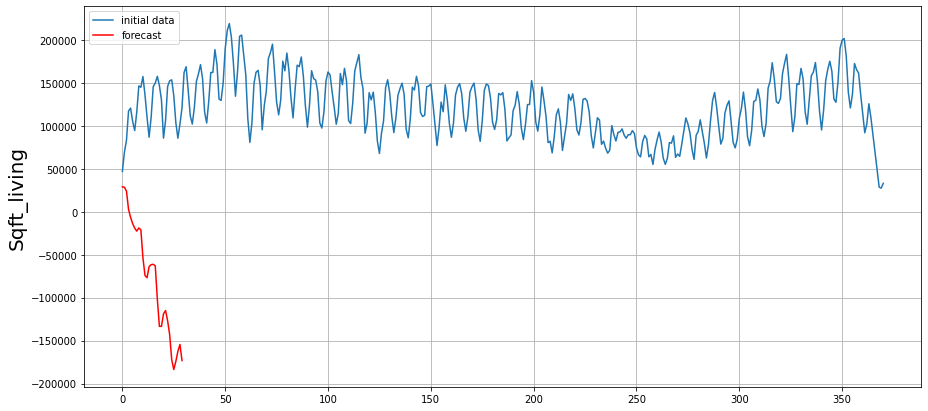

In [113]:
# visualise and compare  
#df_price_year['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize=(15,7))
plt.plot( gaus_list[1], label='initial data')  # df_price_year['date'],
plt.plot( model_sq.predict(start=371, end=400), color='r', label='forecast') # df_price_year['date'],
plt.legend()
plt.ylabel('Sqft_living', fontsize=20);
plt.grid()

In [115]:
prediction = model_sq.predict(start=0, end=370)
print("MSE = ", mean_squared_error(gaus_list[1], prediction))
print("MAE = ", mean_absolute_error(gaus_list[1], prediction))
print("MAPE = ", round(np.mean(np.abs(gaus_list[1]-prediction)/gaus_list[1])*100,3))
print("R^2 = ", r2_score(gaus_list[1], prediction ))

MSE =  158431063.40712386
MAE =  9699.912041984388
MAPE =  9.031
R^2 =  0.8689182539988469
